In [360]:
# survival	Survival 0 = No, 1 = Yes
# pclass Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
# sex Sex 
# Age Age in years
# sibsp # of siblings / spouses aboard the Titanic 
# parch # of parents / children aboard the Titanic 
# ticket Ticket number 
# fare Passenger fare 
# cabin Cabin number 
# embarked Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

# Imports and Loading the Data

In [361]:
import math 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# set file path
filepath = "data/titanic-grid-search/"

# Load train and test datasets
titanic_train_df = pd.read_csv(filepath + 'titanic-train.csv')
titanic_test_df = pd.read_csv(filepath + 'titanic-test.csv')
print(titanic_train_df.head())
print(titanic_test_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

# Preprocessing

In [363]:
# Define a preprocessing function
def preprocess(dfx):
    df = dfx.copy()
    new_df = df[df.columns[~df.columns.isin(['Survived', 'Cabin', 'PassengerId', 'Name', 'Ticket'])]]
    
    new_df_b = new_df.copy()
    new_df_b['Sex'] = np.where(new_df_b['Sex']=='male', 0, 1) 
    new_df_b['Embarked'].fillna('C', inplace=True)
    new_df_b['Embarked'].mask(new_df_b['Embarked']=='S', '1', inplace=True)
    new_df_b['Embarked'].mask(new_df_b['Embarked']=='Q', '2', inplace=True)
    new_df_b['Embarked'].mask(new_df_b['Embarked']=='C', '3', inplace=True)
    new_df_b.fillna(df.mean(), inplace=True)
    return new_df_b

# Create train_df & test_df
x_df = preprocess(titanic_train_df).copy()
y_df = titanic_train_df['Survived']
x_df

Pclass  Sex        Age  SibSp  Parch     Fare Embarked
0         3    0  22.000000      1      0   7.2500        1
1         1    1  38.000000      1      0  71.2833        3
2         3    1  26.000000      0      0   7.9250        1
3         1    1  35.000000      1      0  53.1000        1
4         3    0  35.000000      0      0   8.0500        1
..      ...  ...        ...    ...    ...      ...      ...
886       2    0  27.000000      0      0  13.0000        1
887       1    1  19.000000      0      0  30.0000        1
888       3    1  29.699118      1      2  23.4500        1
889       1    0  26.000000      0      0  30.0000        3
890       3    0  32.000000      0      0   7.7500        2

[891 rows x 7 columns]

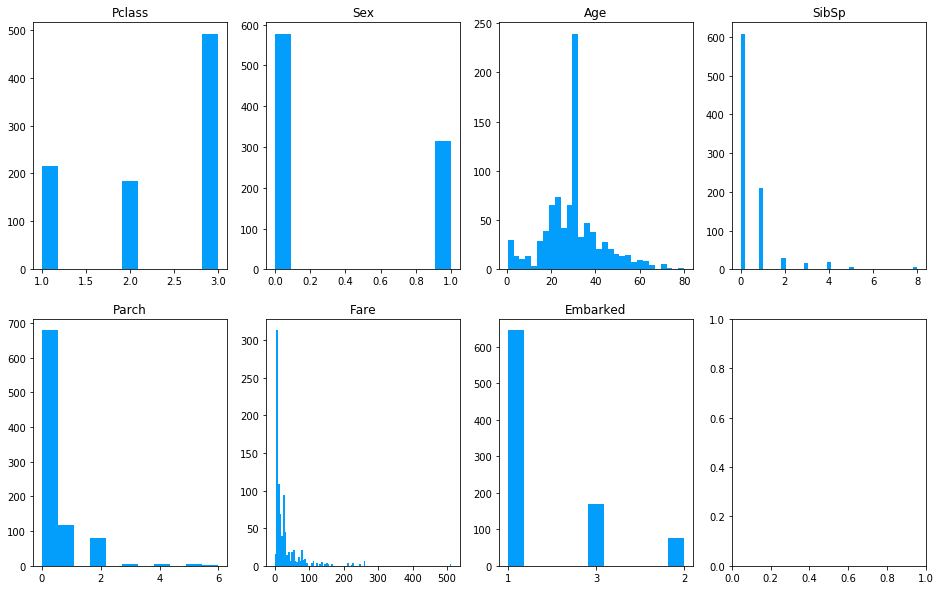

In [364]:
# Histograms for each column
register_matplotlib_converters()
nrows = 2; ncols = int(round(x_df.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=(16, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
columns = x_df.columns
f = 0
for i in range(nrows):
    for j in range(ncols):
        if f <= x_df.shape[1]-1:
            assetname = columns[f]
            y = x_df[assetname]
            ax[i, j].hist(y, color='#039dfc', label=assetname, bins='auto')
            #ax[i, j].set_xlim([y.max(), y.min()])
            f += 1
            ax[i, j].set_title(assetname)
plt.show()

In [365]:
# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.7, random_state=0)

# Hyper-parameter-tuning using Grid Search

([<matplotlib.axis.YTick at 0x223065e4588>,
 <a list of 2 Text yticklabel objects>)

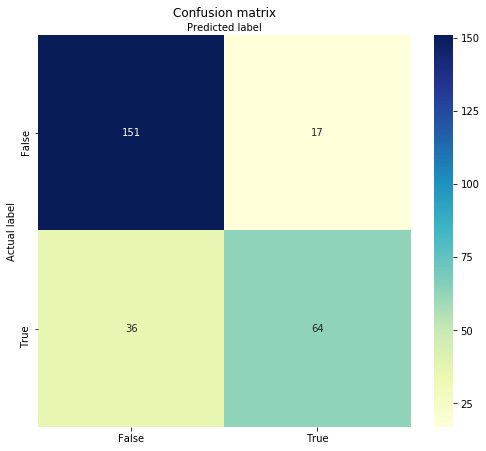

In [366]:
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators = 100)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# create heatmap
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

In [367]:
# Define Parameters
max_depth=[2, 8, 16]
n_estimators = [64, 128, 256]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Build the gridsearch
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(x_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
results_df

Best: [0.78651685 0.79133226 0.79133226 0.81861958 0.80898876 0.82022472
 0.78812199 0.79454254 0.78491172], using {'max_depth': 8, 'n_estimators': 256}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.034520      0.001444         0.004089        0.000535   
1       0.072252      0.012060         0.006868        0.000788   
2       0.134407      0.003858         0.013264        0.000725   
3       0.039913      0.000510         0.004015        0.000643   
4       0.082298      0.002498         0.007933        0.000535   
5       0.162728      0.008288         0.014632        0.001161   
6       0.043434      0.000821         0.004595        0.000494   
7       0.091213      0.005009         0.008157        0.000339   
8       0.171045      0.005360         0.015742        0.000724   

  param_max_depth param_n_estimators                                  params  \
0               2                 64    {'max_depth': 2, 'n_estimators': 64}   
1               2                128   {'max_depth': 2, 'n_estimators': 128}   
2               2                256   {'max_depth': 2, 'n_estimators': 256}   
3               8                 64    {'max_depth': 8, 'n_estimators': 64}   
4               8                128   {'max_depth': 8, 'n_estimators': 128}   
5               8                256   {'max_depth': 8, 'n_estimators': 256}   
6              16                 64   {'max_depth': 16, 'n_estimators': 64}   
7              16                128  {'max_depth': 16, 'n_estimators': 128}   
8              16                256  {'max_depth': 16, 'n_estimators': 256}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.746032              0.832           0.774194           0.798387   
1           0.769841              0.824           0.790323           0.774194   
2           0.777778              0.832           0.790323           0.774194   
3           0.809524              0.824           0.798387           0.798387   
4           0.769841              0.832           0.782258           0.798387   
5           0.777778              0.840           0.798387           0.814516   
6           0.753968              0.800           0.790323           0.766129   
7           0.746032              0.808           0.798387           0.766129   
8           0.738095              0.800           0.782258           0.766129   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.782258         0.786517        0.028433                8  
1           0.798387         0.791332        0.019393                5  
2           0.782258         0.791332        0.021072                5  
3           0.862903         0.818620        0.023996                2  
4           0.862903         0.808989        0.034049                3  
5           0.870968         0.820225        0.032508                1  
6           0.830645         0.788122        0.026858                7  
7           0.854839         0.794543        0.037410                4  
8           0.838710         0.784912        0.033714                9

In [380]:
# Extract single tree
estimator = clf.estimators_[5]
estimator

from sklearn.tree import export_graphviz
# Export as dot file
s = export_graphviz(estimator, 
                out_file='tree.dot', 
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [WinError 2] Das System kann die angegebene Datei nicht finden